In [25]:
import random
import numpy as np
import cv2
import einops
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchvision.transforms import Compose, ToTensor, Lambda, Grayscale
# from IPython.display import Image


def same_seeds(seed):
  # Python built-in random module
  random.seed(seed)
  # Numpy
  np.random.seed(seed)
  # Torch
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

# Set random seed for reproducibility
same_seeds(999)


dataset       = "anime" # anime mnist
workspace_dir = 'v6'

if dataset == 'mnist':
    # Root directory for the MNIST dataset
    dataset_path = f"mnist_dataset"
    # The path to save the model
    model_store_path = f"{dataset}_{workspace_dir}/mnist.pt"
    milestones = [10, 30, 80, 130, 150]
    image_shape = (1,28,28)
    save = 30
elif dataset == 'anime':
    # Root directory for the MNIST dataset
    dataset_path = f"../hw2-1/anime_face_dataset"
    # The path to save the model
    model_store_path = f"{dataset}_{workspace_dir}/anime.pt"
    milestones = [1000, 2000]
    image_shape = (3,64,64)
    save = 50
else:
    raise NotImplementedError()


# Learning rate for optimizers
lr = 1e-5

# Number of the forward steps
n_steps = 1000

# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# List to keep track of loss
loss_list = []


# Load the data, convert it to grayscale, and then normalize it to the range of [-1, 1]
if dataset == 'mnist':
    trans = Compose([
        Grayscale(),
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2)]
    )
elif dataset == 'anime':
    trans = Compose([
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2)]
    )

# Show images
def show_images(images, title=""):
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(title, fontsize=24)
    rows = int(len(images) ** 0.5)
    cols = round(len(images) / rows)
    index = 0
    for row in range(rows):
        for col in range(cols):
            fig.add_subplot(rows, cols, index + 1)
            if index < len(images):
                frame = plt.gca()
                frame.axes.get_yaxis().set_visible(False)
                frame.axes.get_xaxis().set_visible(False)
                temp = np.transpose(images[index], (1, 2, 0))
                plt.imshow((temp+1)/2, cmap='gray' if images[index].shape[0]==1 else None)
                index += 1
    plt.show()


# Define the class of DDPM
class DDPM(nn.Module):
    def __init__(self, image_shape=(1, 28, 28), n_steps=200, start_beta=1e-4, end_beta=0.02, device=None):
        super(DDPM, self).__init__()
        self.device = device
        self.image_shape = image_shape
        self.n_steps = n_steps
        self.noise_predictor = UNet(n_steps, shape = image_shape[-1], channel = image_shape[0]).to(device)
        self.betas = torch.linspace(start_beta, end_beta, n_steps).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    # Forward process
    # Add the noise to the images
    def forward(self, x0, t, eta=None):
        n, channel, height, width = x0.shape
        alpha_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, channel, height, width).to(self.device)

        noise = alpha_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - alpha_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noise

    # Backward process
    # Predict the noise that was added to the images during the forward process
    def backward(self, x, t):
        return self.noise_predictor(x, t)


# Create the time embedding
def time_embedding(n, d):
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])
    return embedding


# Define the class of U-Net
if True or dataset == 'mnist':
    class UNet(nn.Module):
        def __init__(self, n_steps=1000, time_embedding_dim=256, shape = 28, channel = 1):
            super(UNet, self).__init__()

            # Time embedding
            self.time_step_embedding = nn.Embedding(n_steps, time_embedding_dim)
            self.time_step_embedding.weight.data = time_embedding(n_steps, time_embedding_dim)
            self.time_step_embedding.requires_grad_(False)

            # The first half
            self.time_step_encoder1 = nn.Sequential(
                nn.Linear(time_embedding_dim, 1),
                nn.SiLU(),
                nn.Linear(1, 1)
            )

            self.block1 = nn.Sequential(
                nn.LayerNorm((channel, shape, shape)),
                nn.Conv2d(channel, 8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )
            self.down1 = nn.Conv2d(8, 8, 4, 2, 1)

            self.time_step_encoder2 = nn.Sequential(
                nn.Linear(time_embedding_dim, 8),
                nn.SiLU(),
                nn.Linear(8, 8)
            )

            self.block2 = nn.Sequential(
                nn.LayerNorm((8, shape//2, shape//2)),
                nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )
            self.down2 = nn.Conv2d(16, 16, 4, 2, 1)

            self.time_step_encoder3 = nn.Sequential(
                nn.Linear(time_embedding_dim, 16),
                nn.SiLU(),
                nn.Linear(16, 16)
            )

            self.block3 = nn.Sequential(
                nn.LayerNorm((16, shape//4, shape//4)),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )
            if shape == 28:
                self.down3 = nn.Sequential(
                    nn.Conv2d(32, 32, 2, 1),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(32, 32, 4, 2, 1)
                )
            else:
                self.down3 = nn.Sequential(
                    nn.Conv2d(32, 32, 3, 1, 1),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(32, 32, 4, 2, 1),
                )

            # The bottleneck
            self.time_step_encoder_mid = nn.Sequential(
                nn.Linear(time_embedding_dim, 32),
                nn.SiLU(),
                nn.Linear(32, 32)
            )

            self.block_mid = nn.Sequential(
                nn.LayerNorm((32, shape//8, shape//8)),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )

            # The second half
            if shape == 28:
                self.up1 = nn.Sequential(
                    nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1),
                    nn.LeakyReLU(0.2),
                    nn.ConvTranspose2d(32, 32, 2, 1)
                )
            else:
                self.up1 = nn.Sequential(
                    nn.ConvTranspose2d(32, 32, 4, 2, 1),
                    nn.LeakyReLU(0.2),
                    nn.ConvTranspose2d(32, 32, 3, 1, 1)
                )

            self.time_step_encoder4 = nn.Sequential(
                nn.Linear(time_embedding_dim, 64),
                nn.SiLU(),
                nn.Linear(64, 64)
            )

            self.block4 = nn.Sequential(
                nn.LayerNorm((64, shape//4, shape//4)),
                nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )

            self.up2 = nn.ConvTranspose2d(16, 16, 4, 2, 1)

            self.time_step_encoder5 = nn.Sequential(
                nn.Linear(time_embedding_dim, 32),
                nn.SiLU(),
                nn.Linear(32, 32)
            )

            self.block5 = nn.Sequential(
                nn.LayerNorm((32, shape//2, shape//2)),
                nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )

            self.up3 = nn.ConvTranspose2d(8, 8, 4, 2, 1)

            self.time_step_encoder6 = nn.Sequential(
                nn.Linear(time_embedding_dim, 16),
                nn.SiLU(),
                nn.Linear(16, 16)
            )
            self.block6 = nn.Sequential(
                nn.LayerNorm((16, shape, shape)),
                nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                nn.LayerNorm((8, shape, shape)),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
            )

            self.final_layer = nn.Conv2d(8, channel, 3, 1, 1)

        def forward(self, x, t):
            t = self.time_step_embedding(t)
            n = len(x)
            output1 = self.block1(x + self.time_step_encoder1(t).reshape(n, -1, 1, 1))
            output2 = self.block2(self.down1(output1) + self.time_step_encoder2(t).reshape(n, -1, 1, 1))
            output3 = self.block3(self.down2(output2) + self.time_step_encoder3(t).reshape(n, -1, 1, 1))

            output_mid = self.block_mid( self.down3(output3) + self.time_step_encoder_mid(t).reshape(n, -1, 1, 1))

            output4 = torch.cat((output3, self.up1(output_mid)), dim=1)
            output4 = self.block4(output4 + self.time_step_encoder4(t).reshape(n, -1, 1, 1))
            output5 = torch.cat((output2, self.up2(output4)), dim=1)
            output5 = self.block5(output5 + self.time_step_encoder5(t).reshape(n, -1, 1, 1))
            output6 = torch.cat((output1, self.up3(output5)), dim=1)
            output6 = self.block6(output6 + self.time_step_encoder6(t).reshape(n, -1, 1, 1))

            output = self.final_layer(output6)
            return output
    
# else:  
#     class UNet(nn.Module):
#         def __init__(self, n_steps=1000, time_embedding_dim=256, shape = 28, channel = 1):
#             super(UNet, self).__init__()

#             # Time embedding
#             self.time_step_embedding = nn.Embedding(n_steps, time_embedding_dim)
#             self.time_step_embedding.weight.data = time_embedding(n_steps, time_embedding_dim)
#             self.time_step_embedding.requires_grad_(False)

#             # The first half
#             self.time_step_encoder1 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 1),
#                 nn.SiLU(),
#                 nn.Linear(1, 1)
#             )

#             self.block1 = nn.Sequential(
#                 nn.LayerNorm((channel, shape, shape)),
#                 nn.Conv2d(channel, 8, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )
#             self.down1 = nn.Conv2d(8, 8, 4, 2, 1)

#             self.time_step_encoder2 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 8),
#                 nn.SiLU(),
#                 nn.Linear(8, 8)
#             )

#             self.block2 = nn.Sequential(
#                 nn.LayerNorm((8, shape//2, shape//2)),
#                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )
#             self.down2 = nn.Conv2d(16, 16, 4, 2, 1)

#             self.time_step_encoder3 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 16),
#                 nn.SiLU(),
#                 nn.Linear(16, 16)
#             )

#             self.block3 = nn.Sequential(
#                 nn.LayerNorm((16, shape//4, shape//4)),
#                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )
 
#             self.down3 = nn.Sequential(
#                 nn.Conv2d(32, 32, 3, 1, 1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(32, 32, 4, 2, 1),
#             )

#             # The bottleneck
#             self.time_step_encoder_mid = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 32),
#                 nn.SiLU(),
#                 nn.Linear(32, 32)
#             )

#             self.block_mid = nn.Sequential(
#                 nn.LayerNorm((32, shape//8, shape//8)),
#                 nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )

#             # The second half
#             self.up1 = nn.Sequential(
#                 nn.ConvTranspose2d(32, 32, 4, 2, 1),
#                 nn.LeakyReLU(0.2),
#                 nn.ConvTranspose2d(32, 32, 3, 1, 1)
#             )

#             self.time_step_encoder4 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 64),
#                 nn.SiLU(),
#                 nn.Linear(64, 64)
#             )

#             self.block4 = nn.Sequential(
#                 nn.LayerNorm((64, shape//4, shape//4)),
#                 nn.Conv2d(64, 16, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )

#             self.up2 = nn.ConvTranspose2d(16, 16, 4, 2, 1)

#             self.time_step_encoder5 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 32),
#                 nn.SiLU(),
#                 nn.Linear(32, 32)
#             )

#             self.block5 = nn.Sequential(
#                 nn.LayerNorm((32, shape//2, shape//2)),
#                 nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#             )

#             self.up3 = nn.ConvTranspose2d(8, 8, 4, 2, 1)

#             self.time_step_encoder6 = nn.Sequential(
#                 nn.Linear(time_embedding_dim, 16),
#                 nn.SiLU(),
#                 nn.Linear(16, 16)
#             )
#             self.block6 = nn.Sequential(
#                 nn.LayerNorm((16, shape, shape)),
#                 nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.LayerNorm((8, shape, shape)),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
#                 nn.LayerNorm((8, shape, shape)),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
#                 nn.LeakyReLU(0.2),
                
#             )

#             self.final_layer = nn.Conv2d(8, channel, 3, 1, 1)

#         def forward(self, x, t):
#             t = self.time_step_embedding(t)
#             n = len(x)
#             output1 = self.block1(x + self.time_step_encoder1(t).reshape(n, -1, 1, 1))
#             output2 = self.block2(self.down1(output1) + self.time_step_encoder2(t).reshape(n, -1, 1, 1))
#             output3 = self.block3(self.down2(output2) + self.time_step_encoder3(t).reshape(n, -1, 1, 1))

#             output_mid = self.block_mid( self.down3(output3) + self.time_step_encoder_mid(t).reshape(n, -1, 1, 1))

#             output4 = torch.cat((output3, self.up1(output_mid)), dim=1)
#             output4 = self.block4(output4 + self.time_step_encoder4(t).reshape(n, -1, 1, 1))
#             output5 = torch.cat((output2, self.up2(output4)), dim=1)
#             output5 = self.block5(output5 + self.time_step_encoder5(t).reshape(n, -1, 1, 1))
#             output6 = torch.cat((output1, self.up3(output5)), dim=1)
#             output6 = self.block6(output6 + self.time_step_encoder6(t).reshape(n, -1, 1, 1))

#             output = self.final_layer(output6)
#             return output
   

"""
Provided with a DDPM model, a specified number of samples to generate, and a chosen device,
this function returns a set of freshly generated samples while also saving the .gif of the reverse process
"""
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=25, gif_name="sampling.gif", channel=1, height=28, width=28):
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, channel, height, width).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, channel, height, width).to(device)
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)


    if channel == 1:
        for i in range(len(frames)):
            frames[i] = cv2.cvtColor(frames[i], cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(10,10))
    plt.imshow(frames[-1])
    plt.savefig(f'{gif_name.split(".")[0]}.png', bbox_inches='tight')

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

Device: cuda


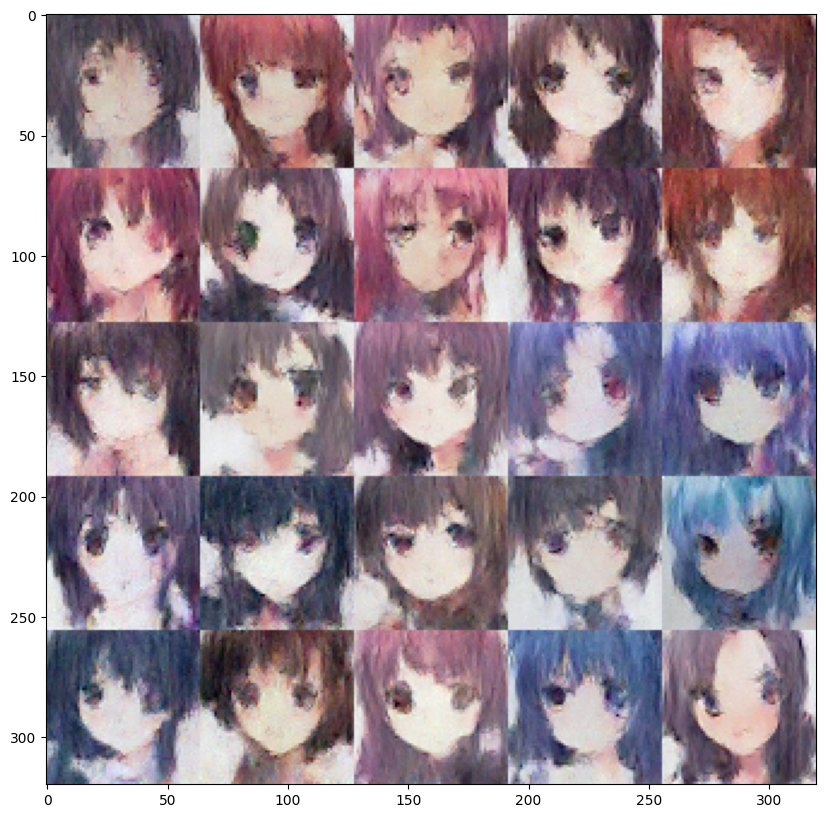

In [26]:
# Build the model
ddpm_mnist = DDPM(image_shape=image_shape, n_steps=n_steps, device=device)

# Load the state of the trained model
ddpm_mnist.load_state_dict(torch.load(model_store_path, map_location=device))

# Change to evaluation mode
ddpm_mnist.eval()

images = generate_new_images(
        ddpm_mnist, 
        n_samples = 25,
        device = device, 
        gif_name=f"result_{dataset}.gif",
        height=image_shape[-1], width=image_shape[-1], channel=image_shape[0])
